### This program attempts to optomize a users portfolio using the Efficient Frontier


In [2]:
import marshal
from datetime import datetime
from textwrap import shorten

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from pypfopt import expected_returns, plotting, risk_models
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt.efficient_frontier import EfficientFrontier

plt.style.use("seaborn-v0_8-dark")
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [3]:
# Get the stocks tickers in the portfolio
# This is an notebook  example to optimse the portfolio
# Lets take as example FAANG
assets = ["META", "AMZN", "AAPL", "NFLX", "GOOG"]

In [4]:
# Assign weights to the stocks, which should addd up to 1
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

In [5]:
# Get the stocks/portfolio start date
start_date = "2013-01-01"

# Get the stocks/portfolio end date
today = datetime.today().strftime("%Y-%m-%d")

In [6]:
# Create a dataframe to store the adjusted close price of the stocks
df = pd.DataFrame()

# Store the adjsuted close price of the sotcks in the dataframe
for stock in assets:
    df[stock] = yf.download(stock, start=start_date, end=today)["Adj Close"]
df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,META,AMZN,AAPL,NFLX,GOOG
Date,,,,,
2013-01-02,27.942579,12.865500,16.725037,13.144286,17.993254
2013-01-03,27.713053,12.924000,16.513927,13.798571,18.003704
2013-01-04,28.701021,12.957500,16.053940,13.711429,18.359463
2013-01-07,29.359669,13.423000,15.959508,14.171429,18.279356
2013-01-08,29.000406,13.319000,16.002459,13.880000,18.243282
...,...,...,...,...,...
2024-07-26,465.700012,182.500000,217.960007,631.369995,168.679993
2024-07-29,465.709991,183.199997,218.240005,626.960022,171.130005
2024-07-30,463.190002,181.710007,218.800003,622.580017,171.860001


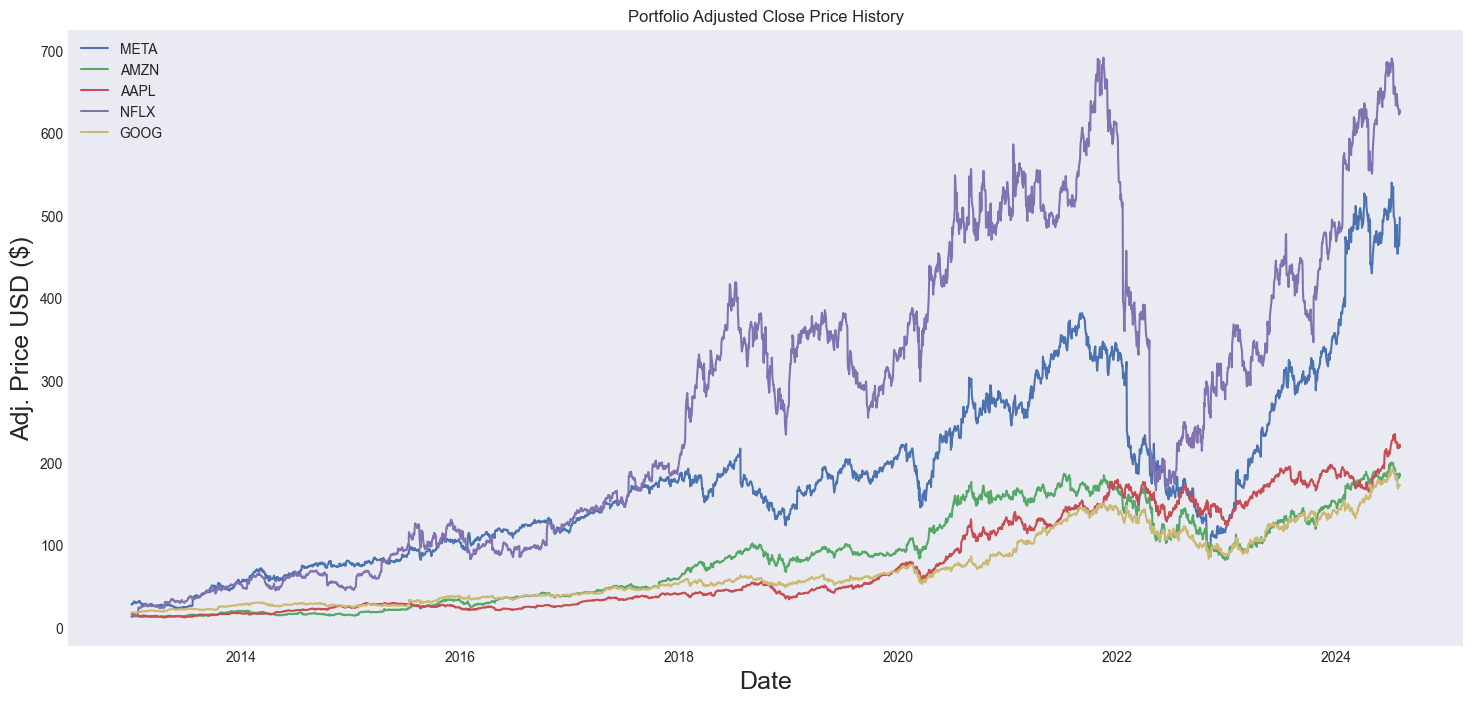

In [7]:
# Visualize the stock / portfolio
title = "Portfolio Adjusted Close Price History"

plt.figure(figsize=(18, 8))

for stock in df.columns.values:
    plt.plot(df[stock], label=stock)

plt.title(title)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Adj. Price USD ($)", fontsize=18)
plt.legend(df.columns.values, loc="upper left")
plt.show()

In [8]:
# Show daily simple return

returns = df.pct_change()
returns

,META,AMZN,AAPL,NFLX,GOOG
Date,,,,,
2013-01-02,NaN,NaN,NaN,NaN,NaN
2013-01-03,-0.008214,0.004547,-0.012622,0.049777,0.000581
2013-01-04,0.035650,0.002592,-0.027855,-0.006315,0.019760
2013-01-07,0.022949,0.035925,-0.005882,0.033549,-0.004363
2013-01-08,-0.012237,-0.007748,0.002691,-0.020565,-0.001973
...,...,...,...,...,...
2024-07-26,0.027106,0.014734,0.002161,-0.004290,-0.002838
2024-07-29,0.000021,0.003836,0.001285,-0.006985,0.014525
2024-07-30,-0.005411,-0.008133,0.002566,-0.006986,0.004266


In [9]:
# Create and show the annualized covariance matrix
# Covariance matrix: Mathematical concept used in Statistics, which determines how much two random variables move together. It is the directional relationship between two assets prices.
# 252 -> nr of trading days in that year.

cov_matrix_annual = returns.cov() * 252
cov_matrix_annual

,META,AMZN,AAPL,NFLX,GOOG
META,0.148389,0.068293,0.050502,0.070971,0.061485
AMZN,0.068293,0.104370,0.044926,0.069945,0.055235
AAPL,0.050502,0.044926,0.079527,0.041543,0.042926
NFLX,0.070971,0.069945,0.041543,0.213649,0.053005
GOOG,0.061485,0.055235,0.042926,0.053005,0.075406


The diagonal line shows the variance of the different assets.
All the other entries are called the covariance.

If we take the square root of variance we get the volatility


In [10]:
# Calculate portfolio variance

portfolio_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
portfolio_variance

0.0695601077066135

In [11]:
# Calculate portfolio volatility aka std. deviation

portfolio_volatility = np.sqrt(portfolio_variance)
portfolio_volatility

0.263742502654793

In [12]:
# Calculate portfolio annual return

portfolio_simple_annual_return = np.sum(returns.mean() * weights) * 252
portfolio_simple_annual_return

0.3081748082332395

In [13]:
# show the expected annual return, volatility (risk), and variance

percent_var = str(round(portfolio_variance, 2) * 100) + "%"
percent_vol = str(round(portfolio_volatility, 2) * 100) + "%"
percent_return = str(round(portfolio_simple_annual_return, 2) * 100) + "%"

print(f"Expected annual return: {percent_return}")
print(f"Annual Volatility/risk: {percent_vol}")
print(f"Annual Variance: {percent_var}")

Expected annual return: 31.0%
Annual Volatility/risk: 26.0%
Annual Variance: 7.000000000000001%


###


### Portfolio Optimization !

- I want to increase Expected annual return, and reducing my risk.


In [14]:
# Calculate the expected returns and the annualised sample covariance matrix of asset returns
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimise for maximum sharpe ratio with objective function:
# Sharp ratio is a way to describe how much excess return you receive for some amount of volatility.
# Measures the performance of an investment compared to a risk-free investment (bonds or Treasury bills)
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.add_constraint(lambda w: w[0] + w[1] + w[2] + w[3] + w[4] == 1)
weights = ef.max_sharpe()

# Helper methods to clean raw methods it sets. Whose absolute value are below some cutoff (defaulted on the method)
# It is going to get rid of the stocks we dont need to optimise the portfolio
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

ef.portfolio_performance(verbose=True)

OrderedDict([('META', 0.09393), ('AMZN', 0.12097), ('AAPL', 0.43862), ('NFLX', 0.28786), ('GOOG', 0.05863)])
Expected annual return: 29.4%
Annual volatility: 26.7%
Sharpe Ratio: 1.03


(0.2937703620876472, 0.26690106649937395, 1.025737235442217)

Doesn't look better, it depends on the year


In [15]:
# Get discrete allocation of each share per stock

latest_prices = get_latest_prices(df)
weights = cleaned_weights
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=15_000)

allocation, leftover = da.lp_portfolio()

print(f"Discrete allocation (shares): {allocation}")
print(f"Funds remaining: ${leftover:.2f}")

Discrete allocation (shares): {'META': 3, 'AMZN': 9, 'AAPL': 30, 'NFLX': 7, 'GOOG': 5}
Funds remaining: $63.15


# For plotting purposes


OrderedDict([('META', 0.09393), ('AMZN', 0.12097), ('AAPL', 0.43862), ('NFLX', 0.28786), ('GOOG', 0.05863)])
Expected annual return: 29.4%
Annual volatility: 26.7%
Sharpe Ratio: 1.03


(0.2937703620876472, 0.26690106649937395, 1.025737235442217)

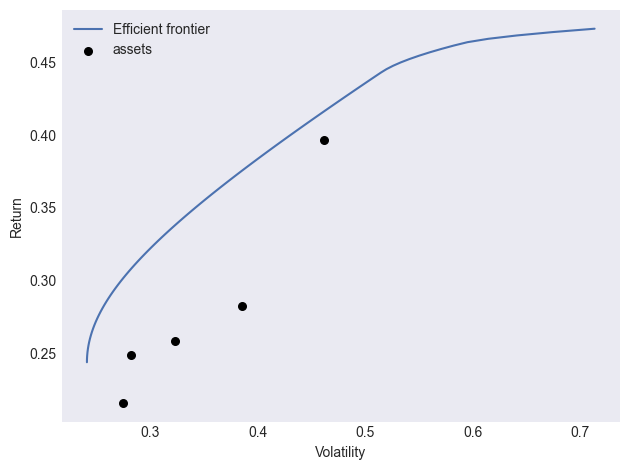

In [16]:
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Create the EfficientFrontier instance
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))

# Add constraints
ef.add_constraint(lambda w: w[0] + w[1] + w[2] + w[3] + w[4] == 1)

# Plot the efficient frontier BEFORE calling the optimization method
plotting.plot_efficient_frontier(ef)

# After plotting, create a new instance for optimization
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.add_constraint(lambda w: w[0] + w[1] + w[2] + w[3] + w[4] == 1)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

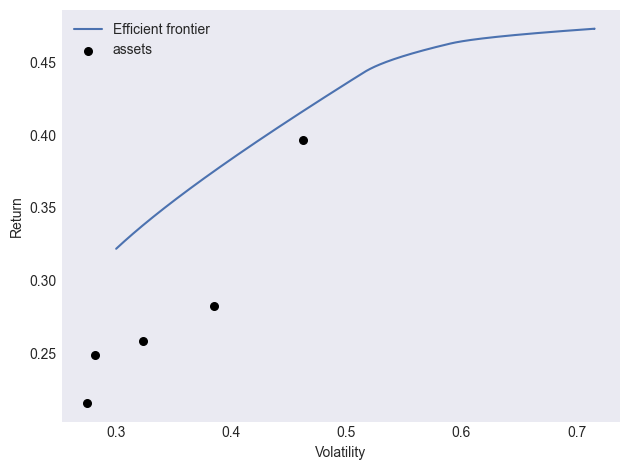

OrderedDict([('META', 0.09393), ('AMZN', 0.12097), ('AAPL', 0.43862), ('NFLX', 0.28786), ('GOOG', 0.05863)])
Expected annual return: 29.4%
Annual volatility: 26.7%
Sharpe Ratio: 1.03


(0.2937703620876472, 0.26690106649937395, 1.025737235442217)

In [17]:
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.add_constraint(lambda w: w[0] + w[1] + w[2] + w[3] + w[4] == 1)

# 1000 portfolios with risk range between 30% and 80%
risk_range = np.linspace(0.30, 0.80, 1000)
plotting.plot_efficient_frontier(
    ef, ef_param="risk", ef_param_range=risk_range, show_assets=True, showfig=True
)

# After plotting, create a new instance for optimization
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.add_constraint(lambda w: w[0] + w[1] + w[2] + w[3] + w[4] == 1)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

### Analyse not only the optimal portfolio as a result Efficient Frontier optimizer


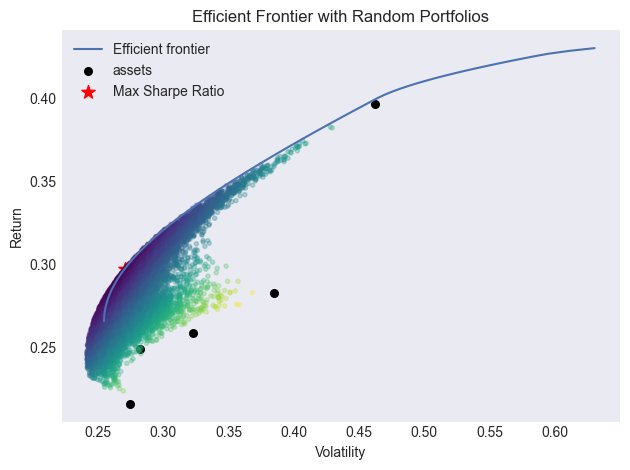

In [18]:
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimize for maximum Sharpe ratio
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.add_constraint(lambda w: w[0] + w[1] + w[2] + w[3] == 1)
weights = ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()

# Create a new instance for plotting the efficient frontier
ef_for_plotting = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef_for_plotting.add_constraint(lambda w: w[0] + w[1] + w[2] + w[3] == 1)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef_for_plotting, ax=ax, show_assets=True)

# Mark the point for max Sharpe ratio on the plot
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe Ratio")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu.T)
stds = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r", alpha=0.3)

# Output
ax.set_title("Efficient Frontier with Random Portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("./figures/ef_scatter_notebook.png")
plt.show()

<Axes: >

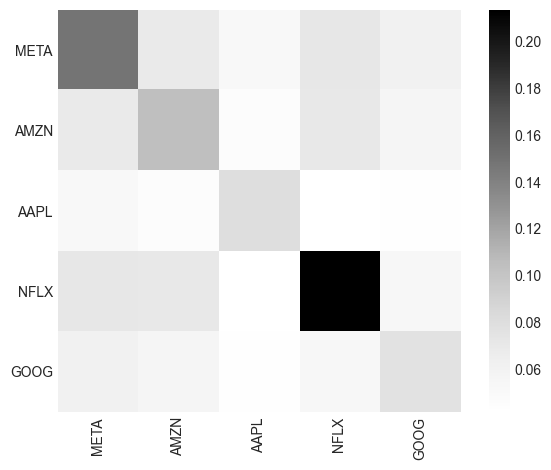

In [19]:
plotting.plot_covariance(S, plot_correlation=False, show_tickers=True)